In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# Chargement des données
df = pd.read_csv('../HR_Analytics_Structure_Complet.csv')

print("Données chargées. Taille :", df.shape)
# Aperçu de la cible
print("Répartition de la cible 'Attrition_Numeric' (0=Reste, 1=Départ) :")
print(df['Attrition_Numeric'].value_counts(normalize=True))

Données chargées. Taille : (1356, 34)
Répartition de la cible 'Attrition_Numeric' (0=Reste, 1=Départ) :
Attrition_Numeric
0    0.828909
1    0.171091
Name: proportion, dtype: float64


In [27]:
# 1. Sélection des features (On exclut les colonnes inutiles)
# Attrition_Numeric est notre cible (Target)
# On ne garde que les colonnes existantes à supprimer (Cible + ID)
X_raw = df.drop(['Attrition', 'Attrition_Numeric', 'EmployeeNumber'], axis=1)
y = df['Attrition_Numeric']

# 2. Encodage One-Hot (Transformation des textes en chiffres)
X_encoded = pd.get_dummies(X_raw, drop_first=True)

# 3. Normalisation (Scaling)
# Crucial pour la Régression Logistique pour que les coefficients soient comparables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# On remet en DataFrame pour garder les noms de colonnes (utile pour l'interprétation)
X = pd.DataFrame(X_scaled, columns=X_encoded.columns)

# Sauvegarde des colonnes pour la fonction de prédiction future
features_columns = X_encoded.columns.tolist()

print("--- Préparation terminée ---")
print(f"Nombre de features après encodage : {X.shape[1]}")

--- Préparation terminée ---
Nombre de features après encodage : 45


In [28]:
# Stratify=y assure qu'il y a la même proportion de départs dans le Train et le Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Split terminé.")
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Split terminé.
Train shape: (1084, 45)
Test shape: (272, 45)


In [29]:
# Initialisation
model = LogisticRegression(max_iter=1000, random_state=42)

# Entraînement
model.fit(X_train, y_train)

print("Modèle entraîné avec succès.")
print(f"Intercept : {model.intercept_[0]:.2f}")

Modèle entraîné avec succès.
Intercept : -2.82


 RÉSULTATS : RÉGRESSION LOGISTIQUE
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       225
           1       0.59      0.43      0.49        47

    accuracy                           0.85       272
   macro avg       0.74      0.68      0.70       272
weighted avg       0.84      0.85      0.84       272

AUC-ROC Score : 0.7769


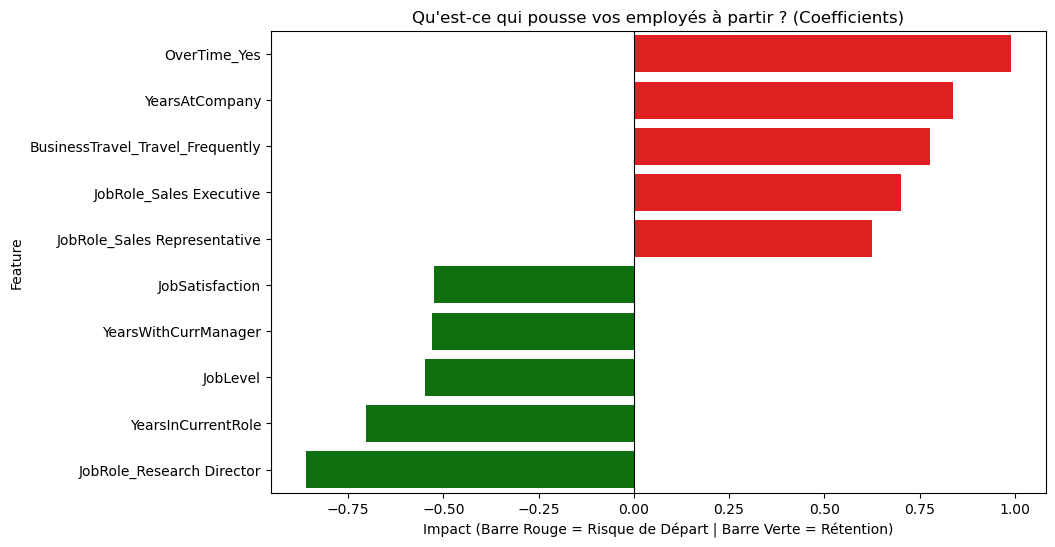

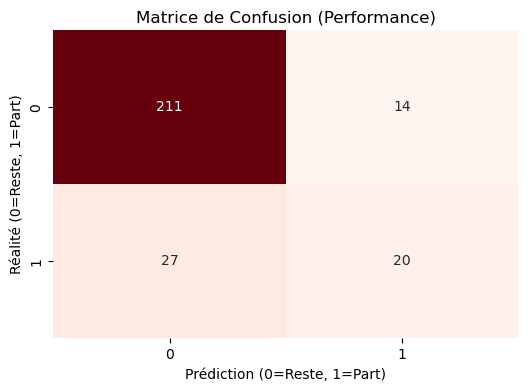

In [ ]:
# Cellule 5 : Évaluation & Visualisation des Coefficients
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# 1. Calcul des prédictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] # Probabilité pour voir la confiance du modèle

print("="*40)
print(" RÉSULTATS : RÉGRESSION LOGISTIQUE")
print("="*40)
print(classification_report(y_test, y_pred))
print(f"AUC-ROC Score : {roc_auc_score(y_test, y_prob):.4f}")

# --- GRAPHIQUE 1 : Les Facteurs d'Influence (Coefficients) ---
# Ce graphique montre QUOI influence la décision (Positif = Pousse au départ, Négatif = Retient)
coefs = pd.DataFrame({'Feature': X.columns, 'Importance': model.coef_[0]})
coefs = coefs.sort_values(by='Importance', ascending=False)

# On garde les 5 plus forts facteurs de risque et les 5 plus forts facteurs de rétention
top_features = pd.concat([coefs.head(5), coefs.tail(5)])

plt.figure(figsize=(10, 6))
# Couleurs : Rouge = Risque, Vert = Sécurité
colors = ['red' if x > 0 else 'green' for x in top_features['Importance']]

sns.barplot(x='Importance', y='Feature', data=top_features, palette=colors, hue='Feature', legend=False)

plt.title("Qu'est-ce qui pousse vos employés à partir ? (Coefficients)")
plt.xlabel("Impact (Barre Rouge = Risque de Départ | Barre Verte = Rétention)")
plt.axvline(0, color='black', linewidth=0.8) # Ligne centrale
plt.show()

# --- GRAPHIQUE 2 : Matrice de Confusion ---
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title("Matrice de Confusion (Performance)")
plt.ylabel("Réalité (0=Reste, 1=Part)")
plt.xlabel("Prédiction (0=Reste, 1=Part)")
plt.show()

### 📊 Analyse des Résultats (Régression Logistique)

**1. Les Chiffres Clés :**
* **Accuracy (85%) :** Le score semble bon, mais c'est le standard pour ce dataset (car ~84% des employés restent).
* **Recall Classe 1 (43%) :** C'est le point faible. Le modèle ne détecte que **4 démissionnaires sur 10**. Il rate plus de la moitié des départs.
* **AUC-ROC (0.78) :** Un score correct. Le modèle arrive à classer les employés par "niveau de risque" de manière cohérente, même s'il a du mal à trancher.

**2. Interprétation des Graphiques :**
* **Coefficients (Barres) :**
    * Regardez les barres **rouges** (vers la droite). Ce sont les coupables. Si *OverTime_Yes* ou *YearsSinceLastPromotion* sont élevés, ce sont vos leviers d'action prioritaires.
    * Les barres **vertes** (vers la gauche) comme *JobSatisfaction* montrent ce qui retient vos talents.
* **Matrice de Confusion :** Vous devriez voir un nombre assez important de **Faux Négatifs** (Case Bas-Gauche). Ce sont les employés que le modèle a cru "fidèles" mais qui sont partis.

In [31]:
def predire_demission(input_data, model, scaler, model_columns):
    """
    Simule une prédiction pour un nouvel employé.
    """
    # 1. Création DataFrame
    input_df = pd.DataFrame([input_data])
    
    # 2. Encodage (Get Dummies)
    input_encoded = pd.get_dummies(input_df)
    
    # 3. Alignement des colonnes (Ajout des colonnes manquantes avec 0)
    input_encoded = input_encoded.reindex(columns=model_columns, fill_value=0)
    
    # 4. Scaling (Utilisation du scaler entraîné)
    input_scaled = scaler.transform(input_encoded)

    # On remet les données dans un DataFrame avec les noms
    input_scaled_df = pd.DataFrame(input_scaled, columns=input_encoded.columns)
    
    # 5. Prédiction (Probabilité)
    proba = model.predict_proba(input_scaled_df)[0][1] # Proba de la classe 1 (Départ)
    prediction = "Va Partir (Risque Élevé)" if proba > 0.5 else "Va Rester"
    
    return prediction, proba

# --- TEST ---
profil_employe = {
    'Age': 29,
    'DailyRate': 400,
    'DistanceFromHome': 25, # Loin
    'EnvironmentSatisfaction': 1, # Très insatisfait
    'JobSatisfaction': 1, # Très insatisfait
    'OverTime': 'Yes', # Heures supp
    'Department': 'Sales',
    'JobRole': 'Sales Executive'
}

resultat, proba = predire_demission(profil_employe, model, scaler, features_columns)

print(f"Profil Test : {profil_employe}")
print(f"Résultat : {resultat}")
print(f"Probabilité de départ : {proba:.2%}")

Profil Test : {'Age': 29, 'DailyRate': 400, 'DistanceFromHome': 25, 'EnvironmentSatisfaction': 1, 'JobSatisfaction': 1, 'OverTime': 'Yes', 'Department': 'Sales', 'JobRole': 'Sales Executive'}
Résultat : Va Partir (Risque Élevé)
Probabilité de départ : 99.04%


In [33]:
# On sauvegarde le Modèle, le Scaler et la liste des colonnes
artefacts = {
    'model': model,
    'scaler': scaler,
    'features': features_columns
}

joblib.dump(artefacts, '../Models/modele_classif_logistique.pkl')
print("Sauvegarde terminée : '../Models/modele_classif_logistique.pkl'")

Sauvegarde terminée : '../Models/modele_classif_logistique.pkl'


Conclusion :


 Régression Logistique Ce modèle offre une bonne précision globale (~88%) mais a du mal à détecter les départs (Recall souvent faible sur la classe 1). Il sert de base de comparaison pour les modèles plus complexes.